# Holt-Winters Exponential Smoothing

### Pre-Processing

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from matplotlib.dates import AutoDateLocator, DateFormatter

#Define the base directory
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, 'Hourly Energy Consumption')

#Define utilities with file names
utilities = {
    'AEP': 'AEP_hourly.csv',
    'COMED': 'COMED_hourly.csv',
    'DAYTON': 'DAYTON_hourly.csv',
    'DEOK': 'DEOK_hourly.csv',
    'DOM': 'DOM_hourly.csv',
    'DUQ': 'DUQ_hourly.csv',
    'EKPC': 'EKPC_hourly.csv',
    'FE': 'FE_hourly.csv',
    'NI': 'Ni_hourly.csv',
    'PJMW': 'PJMW_hourly.csv'
}

In [2]:
#Function to remove outliers
def remove_outliers(series, threshold=3):
    mean = series.mean()
    std = series.std()
    return series[(series > mean - threshold * std) & (series < mean + threshold * std)]

#Function to handle duplicate timestamps
def handle_duplicates(df, mw_col):
    #Group by index and aggregate using mean
    df = df.groupby(df.index).mean()
    return df

#Function to apply exponential smoothing and forecast
def apply_exponential_smoothing(utility_file, utility_name):
    #Check if file exists
    file_path = os.path.join(base_dir, utility_file)
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} not found. Please check the path.")
    
    #Read data
    df = pd.read_csv(file_path)
    df['Datetime'] = pd.to_datetime(df['Datetime'], format='mixed')
    df.set_index('Datetime', inplace=True)
    mw_col = f'{utility_name}_MW'
    
    if mw_col not in df.columns:
        raise ValueError(f"Column {mw_col} not found in the dataset.")
    
    #Handle duplicates
    df = handle_duplicates(df, mw_col)
    
    #Remove outliers
    df[mw_col] = remove_outliers(df[mw_col])
    df = df.dropna()
    
    #Train-test split: 80% for training, 20% for testing
    train_size = int(0.8 * len(df))
    train_data = df[mw_col][:train_size]
    test_data = df[mw_col][train_size:]
    
    #Apply Holt-Winters Exponential Smoothing
    model = ExponentialSmoothing(
        train_data,
        seasonal='add',
        seasonal_periods=24  # Assuming hourly data with daily seasonality
    ).fit()
    
    #Forecast
    forecast = model.forecast(len(test_data))
    
    #Evaluate performance
    mape = mean_absolute_percentage_error(test_data, forecast)
    mse = mean_squared_error(test_data, forecast)
    
    print(f"{utility_name} - MAPE: {mape:.2f}, MSE: {mse:.2f}")
    return train_data, test_data, forecast


### Checking Data

In [ ]:
# Create subplot grid
fig, axes = plt.subplots(2, 5, figsize=(24, 10))
axes = axes.flatten()

# Set the figure title
fig.suptitle("Utility Energy Consumption Forecast vs Actuals", fontsize=16)

for idx, (utility, filename) in enumerate(utilities.items()):
    try:
        # Apply the smoothing and get train, test, and forecast data
        train, test, forecast = apply_exponential_smoothing(filename, utility)

        # Plot the train, test, and forecast values
        axes[idx].plot(train.index, train, label='Train', color='blue', linewidth=1.2)
        axes[idx].plot(test.index, test, label='Actual', color='orange', linewidth=1.2)
        axes[idx].plot(test.index, forecast, label='Forecast', color='green', linestyle='--', linewidth=1.2)

        # Set title, labels, and limits
        axes[idx].set_title(f'{utility} Exponential Smoothing', fontsize=12)
        axes[idx].set_xlabel('Datetime', fontsize=10)
        axes[idx].set_ylabel('MW', fontsize=10)
        axes[idx].set_ylim(bottom=0)  # Ensure the y-axis starts at zero for consistency

        # Improve x-axis formatting for better readability
        locator = AutoDateLocator()
        axes[idx].xaxis.set_major_locator(locator)
        axes[idx].xaxis.set_major_formatter(DateFormatter('%b %Y'))
        plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=45, ha="right", fontsize=8)

        # Set the legend position to minimize overlap with the data
        axes[idx].legend(loc='upper left', fontsize=8)

    except FileNotFoundError as fnf_error:
        print(f"Error processing {utility}: {fnf_error}")
        axes[idx].set_title(f"{utility} - File Not Found", fontsize=12)
        axes[idx].axis('off')  # Turn off axis if data is not available
    except Exception as e:
        print(f"Unexpected error processing {utility}: {str(e)}")
        axes[idx].set_title(f"{utility} - Error", fontsize=12)
        axes[idx].axis('off')  # Turn off axis if data is not available

# Adjust layout to ensure titles and labels do not overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


# Seprating Seasonally

In [ ]:
#Set up the seasonal component
seasonal_periods = 24  #For hourly data with daily seasonality, set to 24
seasonal_type = "mul"  #Switched to multiplicative component to handle varying seasonal patterns

#Print out seasonal parameters to confirm
print(f"Seasonal Type: {seasonal_type}")
print(f"Seasonal Periods: {seasonal_periods}")

Seasonal Type: mul
Seasonal Periods: 24


In [ ]:
#List of filenames for each utility dataset
utilities = [
    "AEP_hourly.csv",
    "COMED_hourly.csv",
    "DAYTON_hourly.csv",
    "DEOK_hourly.csv",
    "DOM_hourly.csv",
    "DUQ_hourly.csv",
    "EKPC_hourly.csv",
    "FE_hourly.csv",
    "NI_hourly.csv",
    "PJMW_hourly.csv"
]

#Define utility names that match each dataset in a descriptive manner
utility_names = [
    "AEP Utility",
    "COMED Utility",
    "DAYTON Utility",
    "DEOK Utility",
    "DOM Utility",
    "DUQ Utility",
    "EKPC Utility",
    "FE Utility",
    "NI Load Utility",
    "PJMW Utility"
]

### Orginal Models

Duplicate timestamps found in AEP Utility, handling duplicates.
Missing values were filled in AEP Utility.


C:\Users\prian\AppData\Local\Temp\ipykernel_2484\4216680540.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utility_data = utility_data.asfreq("H")
C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


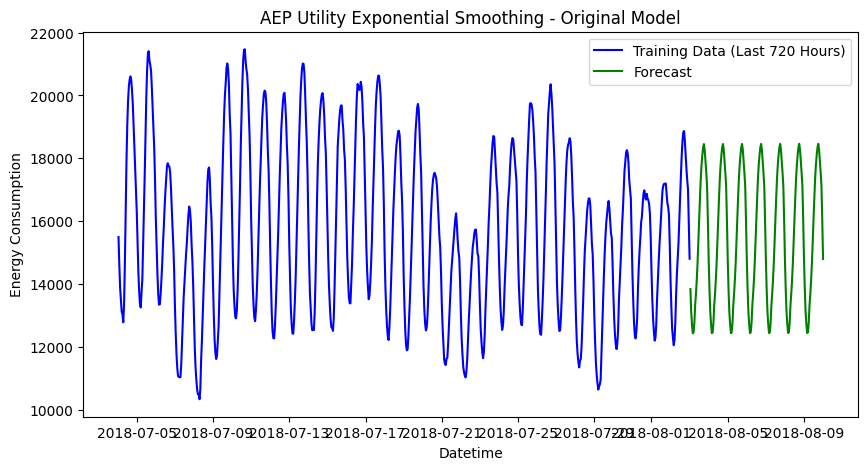

Root Mean Square Error (RMSE) for AEP Utility - Original Model: 1073.41

Duplicate timestamps found in COMED Utility, handling duplicates.
Missing values were filled in COMED Utility.


C:\Users\prian\AppData\Local\Temp\ipykernel_2484\4216680540.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utility_data = utility_data.asfreq("H")
C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


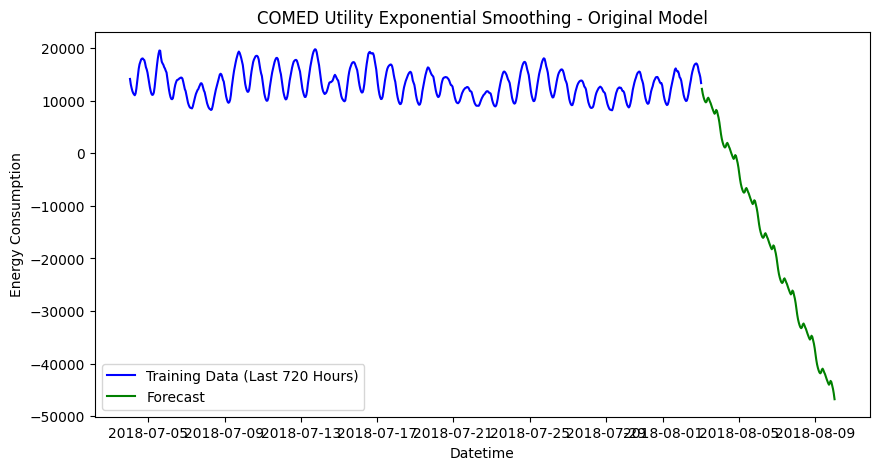

Root Mean Square Error (RMSE) for COMED Utility - Original Model: 34207.74

Duplicate timestamps found in DAYTON Utility, handling duplicates.
Missing values were filled in DAYTON Utility.


C:\Users\prian\AppData\Local\Temp\ipykernel_2484\4216680540.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utility_data = utility_data.asfreq("H")
C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


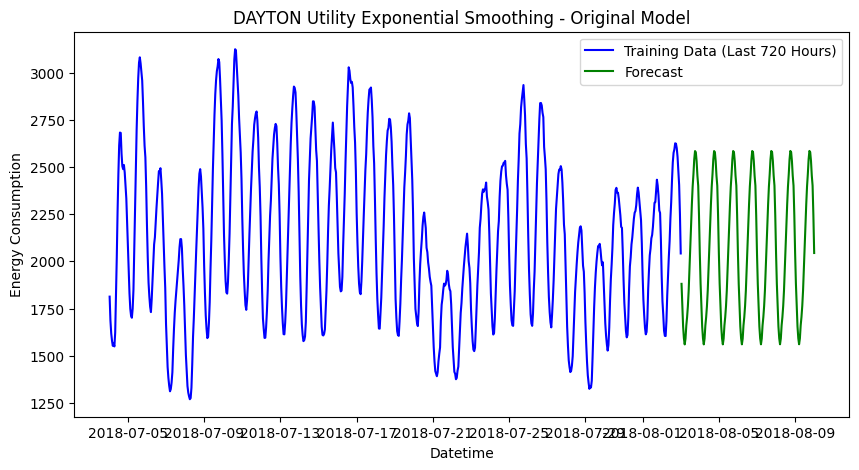

Root Mean Square Error (RMSE) for DAYTON Utility - Original Model: 221.83

Duplicate timestamps found in DEOK Utility, handling duplicates.
Missing values were filled in DEOK Utility.


C:\Users\prian\AppData\Local\Temp\ipykernel_2484\4216680540.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utility_data = utility_data.asfreq("H")
C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


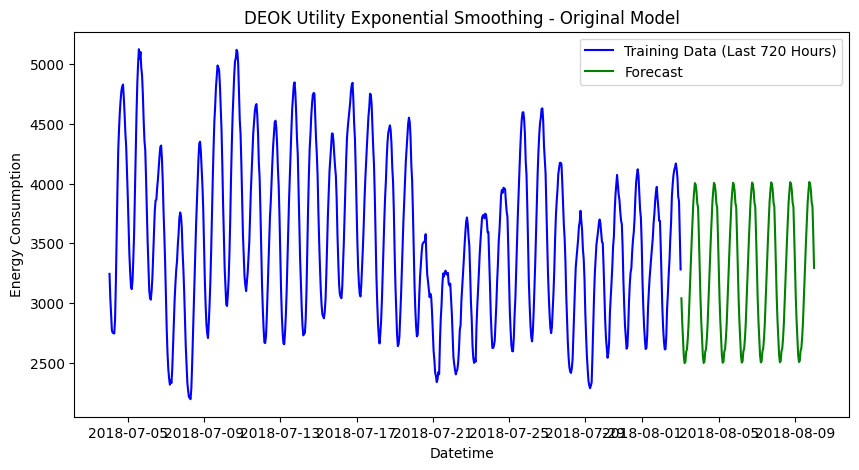

Root Mean Square Error (RMSE) for DEOK Utility - Original Model: 279.53

Duplicate timestamps found in DOM Utility, handling duplicates.
Missing values were filled in DOM Utility.


C:\Users\prian\AppData\Local\Temp\ipykernel_2484\4216680540.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utility_data = utility_data.asfreq("H")
C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


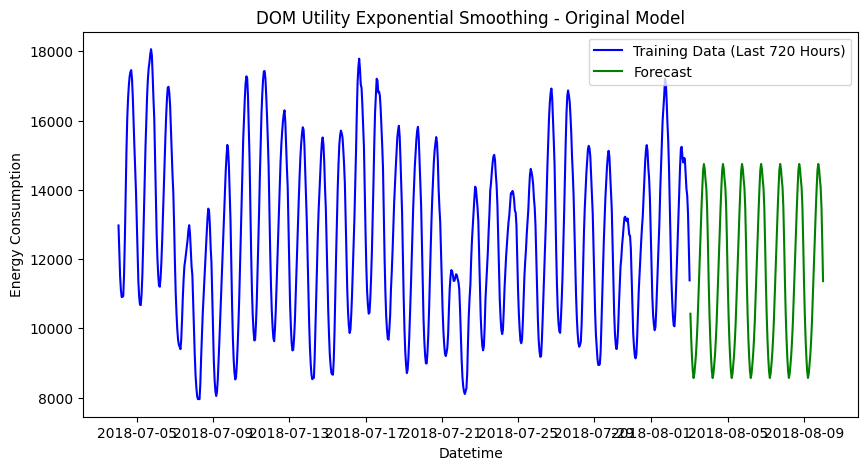

Root Mean Square Error (RMSE) for DOM Utility - Original Model: 1547.21

Duplicate timestamps found in DUQ Utility, handling duplicates.
Missing values were filled in DUQ Utility.


C:\Users\prian\AppData\Local\Temp\ipykernel_2484\4216680540.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utility_data = utility_data.asfreq("H")
C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


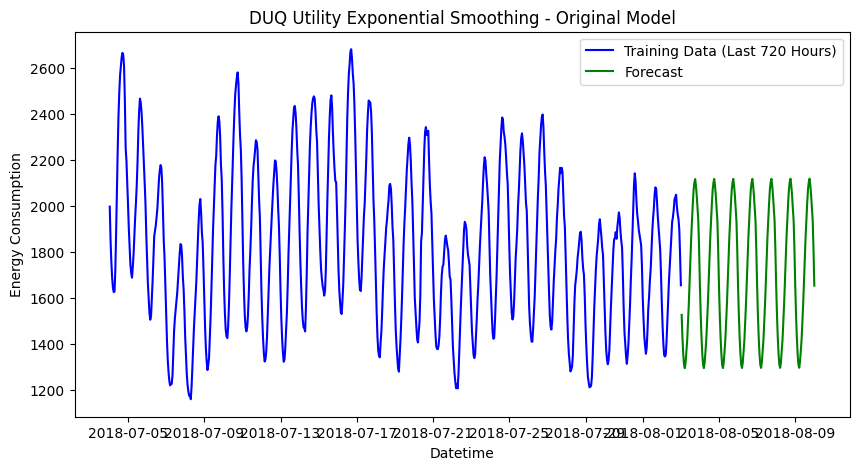

Root Mean Square Error (RMSE) for DUQ Utility - Original Model: 131.72

Duplicate timestamps found in EKPC Utility, handling duplicates.
Missing values were filled in EKPC Utility.


C:\Users\prian\AppData\Local\Temp\ipykernel_2484\4216680540.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utility_data = utility_data.asfreq("H")
C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


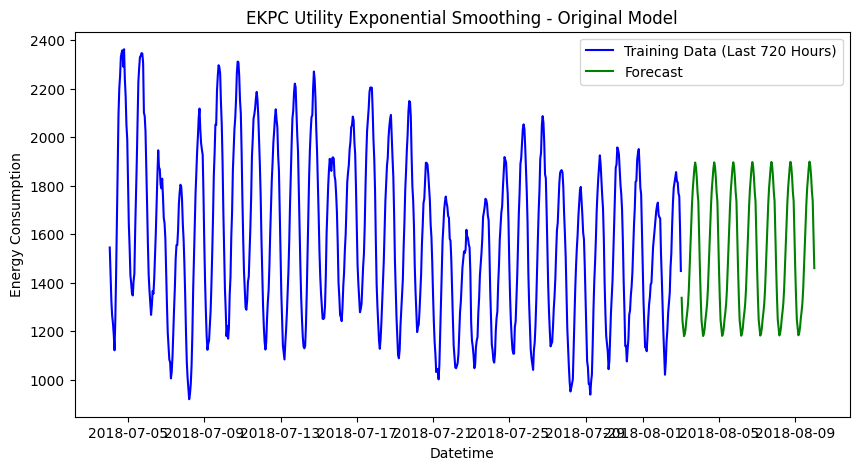

Root Mean Square Error (RMSE) for EKPC Utility - Original Model: 98.64

Duplicate timestamps found in FE Utility, handling duplicates.
Missing values were filled in FE Utility.


C:\Users\prian\AppData\Local\Temp\ipykernel_2484\4216680540.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utility_data = utility_data.asfreq("H")
C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


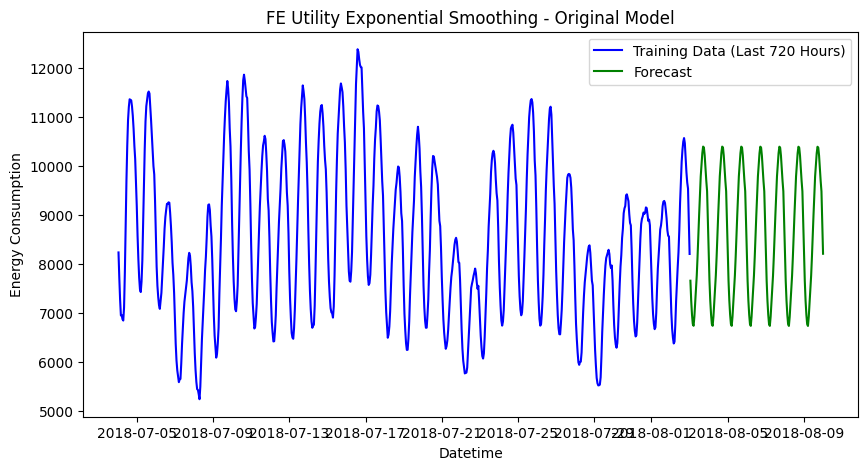

Root Mean Square Error (RMSE) for FE Utility - Original Model: 983.68

Missing values were filled in NI Load Utility.


C:\Users\prian\AppData\Local\Temp\ipykernel_2484\4216680540.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utility_data = utility_data.asfreq("H")
C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


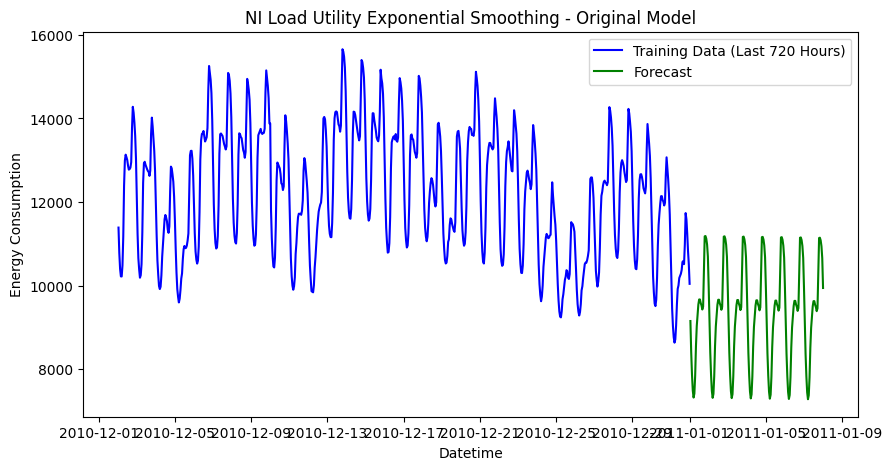

Root Mean Square Error (RMSE) for NI Load Utility - Original Model: 2218.92

Duplicate timestamps found in PJMW Utility, handling duplicates.


C:\Users\prian\AppData\Local\Temp\ipykernel_2484\4216680540.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utility_data = utility_data.asfreq("H")


Missing values were filled in PJMW Utility.


C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


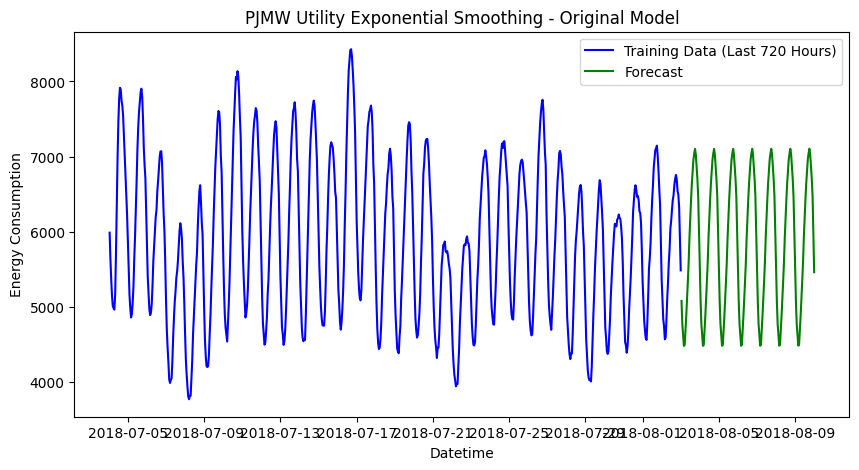

Root Mean Square Error (RMSE) for PJMW Utility - Original Model: 375.18



In [ ]:
for utility_file, utility_name in zip(utilities, utility_names):
    file_path = os.path.join(base_dir, utility_file)

    # Load and prepare data
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")
        continue

    try:
        utility_data = pd.read_csv(file_path, index_col=0)
    except Exception as e:
        print(f"Error loading {utility_name}: {e}")
        continue

    utility_data.index = pd.to_datetime(utility_data.index)

    # Handle duplicate timestamps
    if utility_data.index.duplicated().any():
        print(f"Duplicate timestamps found in {utility_name}, handling duplicates.")
        utility_data = utility_data[~utility_data.index.duplicated(keep='first')]

    # Ensure the data frequency is hourly
    utility_data = utility_data.asfreq("H")

    # Check and fill missing values if necessary
    if utility_data.isnull().sum().sum() > 0:
        utility_data = utility_data.ffill()
        print(f"Missing values were filled in {utility_name}.")

    # Apply the Holt-Winters model with default settings
    try:
        model = ExponentialSmoothing(
            utility_data,
            trend="add",
            seasonal="add",
            seasonal_periods=seasonal_periods
        )
        model_fit = model.fit(optimized=True)
        forecast = model_fit.forecast(steps=168)

        # Plotting the actual and predicted values
        plt.figure(figsize=(10, 5))
        plt.plot(utility_data[-720:], label="Training Data (Last 720 Hours)", color="blue")
        plt.plot(forecast, label="Forecast", color="green")
        plt.title(f"{utility_name} Exponential Smoothing - Original Model")
        plt.xlabel("Datetime")
        plt.ylabel("Energy Consumption")
        plt.legend()
       
        locator = AutoDateLocator()  # Automatically set tick locations
        formatter = DateFormatter('%b %d, %Y')  # Set the date format to be more readable
        plt.gca().xaxis.set_major_locator(locator)  # Apply locator to the x-axis
        plt.gca().xaxis.set_major_formatter(formatter)  # Apply formatter to the x-axis
        plt.xticks(rotation=45, ha='right')  # Rotate the ticks for better readability

        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()

        #Calculate RMSE for forecast
        test_data = utility_data[-168:]  # Assuming test data is the last week
        rmse = np.sqrt(mean_squared_error(test_data, forecast))
        print(f"Root Mean Square Error (RMSE) for {utility_name} - Original Model: {rmse:.2f}\n")

    except Exception as e:
        print(f"Error fitting original model for {utility_name}: {e}\n")

### Hyperparameter-Tuned Model

Attempting to load file: c:\Users\prian\OneDrive\Desktop\FDS Project\Hourly Energy Consumption\AEP_hourly.csv
Duplicate timestamps found in AEP Utility, handling duplicates.
Missing values were filled in AEP Utility.


C:\Users\prian\AppData\Local\Temp\ipykernel_2484\4232841655.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utility_data = utility_data.asfreq("H")
C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


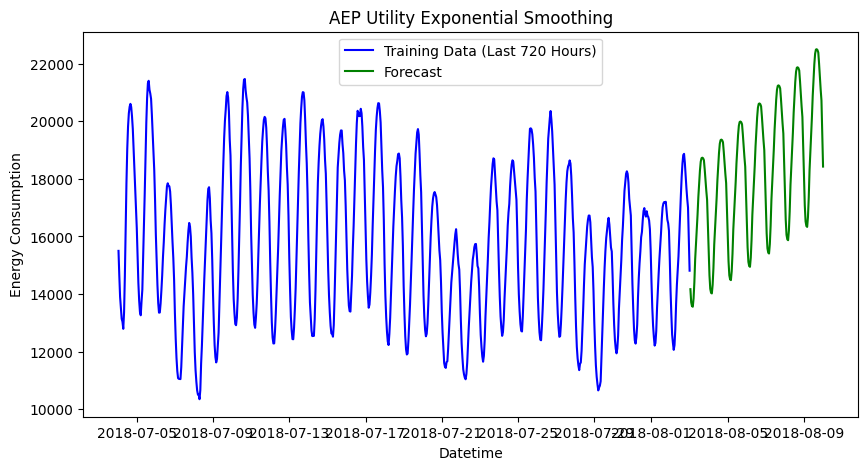

Root Mean Square Error (RMSE) for AEP Utility: 3451.50
Attempting to load file: c:\Users\prian\OneDrive\Desktop\FDS Project\Hourly Energy Consumption\COMED_hourly.csv
Duplicate timestamps found in COMED Utility, handling duplicates.
Missing values were filled in COMED Utility.


C:\Users\prian\AppData\Local\Temp\ipykernel_2484\4232841655.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utility_data = utility_data.asfreq("H")
C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


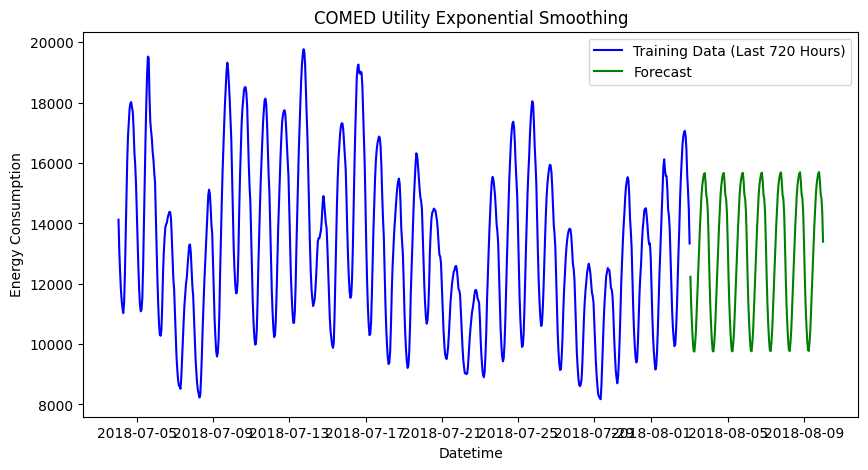

Root Mean Square Error (RMSE) for COMED Utility: 1541.61
Attempting to load file: c:\Users\prian\OneDrive\Desktop\FDS Project\Hourly Energy Consumption\DAYTON_hourly.csv
Duplicate timestamps found in DAYTON Utility, handling duplicates.
Missing values were filled in DAYTON Utility.


C:\Users\prian\AppData\Local\Temp\ipykernel_2484\4232841655.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utility_data = utility_data.asfreq("H")
C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


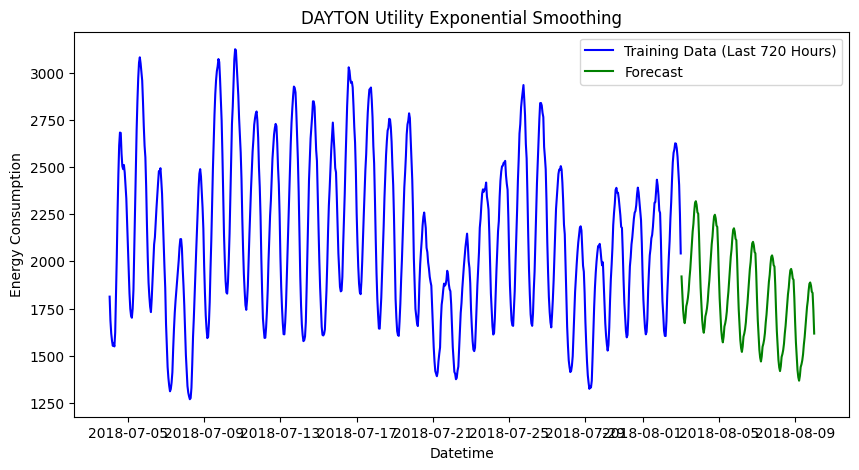

Root Mean Square Error (RMSE) for DAYTON Utility: 334.01
Attempting to load file: c:\Users\prian\OneDrive\Desktop\FDS Project\Hourly Energy Consumption\DEOK_hourly.csv
Duplicate timestamps found in DEOK Utility, handling duplicates.
Missing values were filled in DEOK Utility.


C:\Users\prian\AppData\Local\Temp\ipykernel_2484\4232841655.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utility_data = utility_data.asfreq("H")
C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


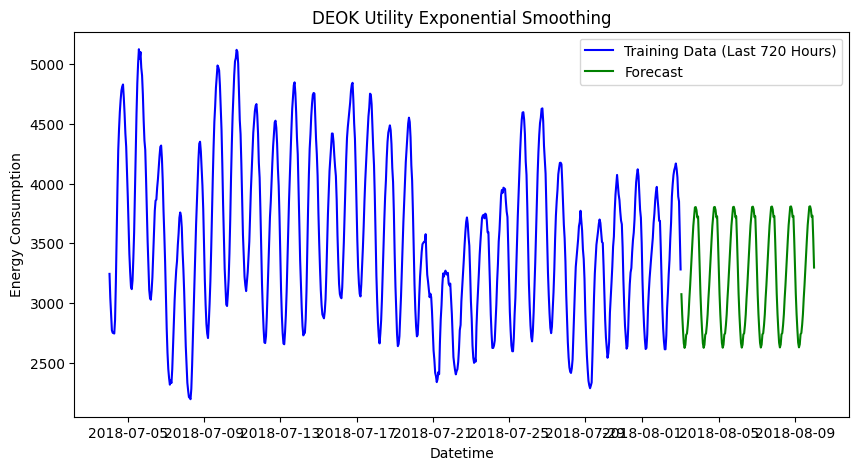

Root Mean Square Error (RMSE) for DEOK Utility: 285.55
Attempting to load file: c:\Users\prian\OneDrive\Desktop\FDS Project\Hourly Energy Consumption\DOM_hourly.csv
Duplicate timestamps found in DOM Utility, handling duplicates.
Missing values were filled in DOM Utility.


C:\Users\prian\AppData\Local\Temp\ipykernel_2484\4232841655.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utility_data = utility_data.asfreq("H")
C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


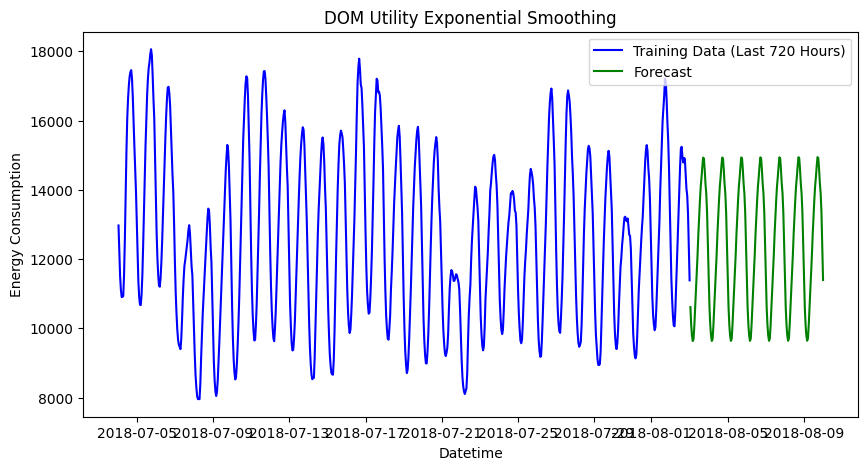

Root Mean Square Error (RMSE) for DOM Utility: 917.11
Attempting to load file: c:\Users\prian\OneDrive\Desktop\FDS Project\Hourly Energy Consumption\DUQ_hourly.csv
Duplicate timestamps found in DUQ Utility, handling duplicates.


C:\Users\prian\AppData\Local\Temp\ipykernel_2484\4232841655.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utility_data = utility_data.asfreq("H")


Missing values were filled in DUQ Utility.


C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


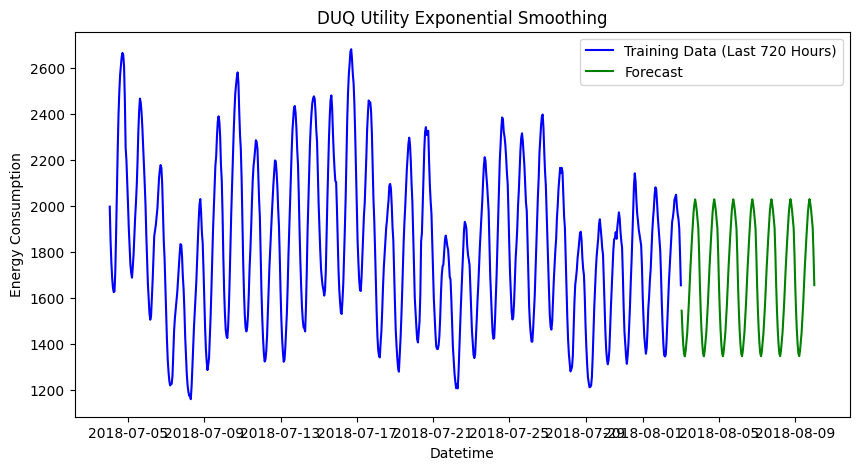

Root Mean Square Error (RMSE) for DUQ Utility: 120.80
Attempting to load file: c:\Users\prian\OneDrive\Desktop\FDS Project\Hourly Energy Consumption\EKPC_hourly.csv
Duplicate timestamps found in EKPC Utility, handling duplicates.
Missing values were filled in EKPC Utility.


C:\Users\prian\AppData\Local\Temp\ipykernel_2484\4232841655.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utility_data = utility_data.asfreq("H")
C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


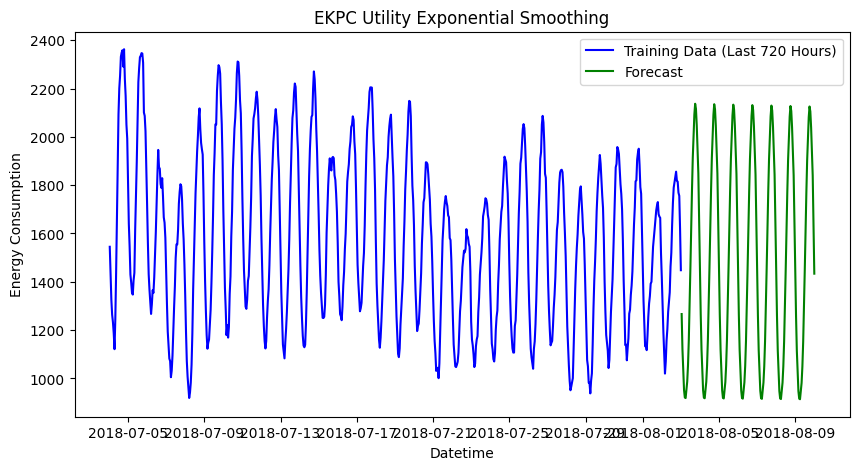

Root Mean Square Error (RMSE) for EKPC Utility: 188.66
Attempting to load file: c:\Users\prian\OneDrive\Desktop\FDS Project\Hourly Energy Consumption\FE_hourly.csv
Duplicate timestamps found in FE Utility, handling duplicates.
Missing values were filled in FE Utility.
Dataset for FE Utility contains non-positive values. Switching to additive model.


C:\Users\prian\AppData\Local\Temp\ipykernel_2484\4232841655.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utility_data = utility_data.asfreq("H")
C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


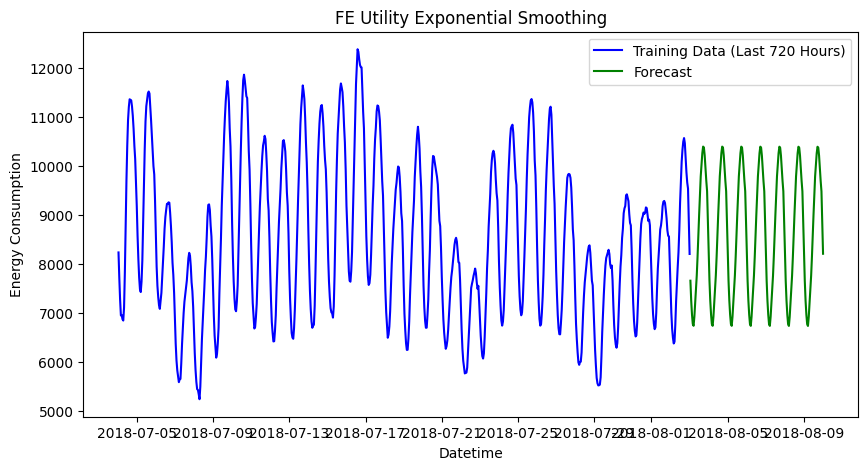

Root Mean Square Error (RMSE) for FE Utility: 983.68
Attempting to load file: c:\Users\prian\OneDrive\Desktop\FDS Project\Hourly Energy Consumption\NI_hourly.csv
Missing values were filled in NI Load Utility.


C:\Users\prian\AppData\Local\Temp\ipykernel_2484\4232841655.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utility_data = utility_data.asfreq("H")
C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


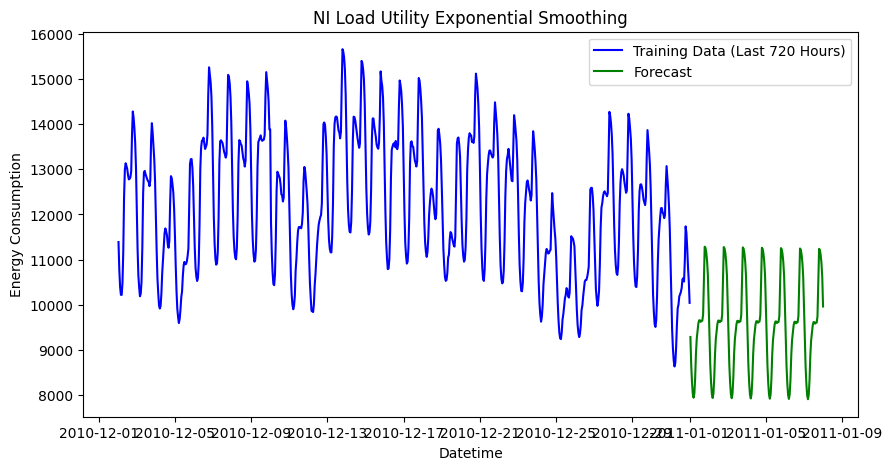

Root Mean Square Error (RMSE) for NI Load Utility: 2023.43
Attempting to load file: c:\Users\prian\OneDrive\Desktop\FDS Project\Hourly Energy Consumption\PJMW_hourly.csv
Duplicate timestamps found in PJMW Utility, handling duplicates.


C:\Users\prian\AppData\Local\Temp\ipykernel_2484\4232841655.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utility_data = utility_data.asfreq("H")


Missing values were filled in PJMW Utility.


C:\Users\prian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


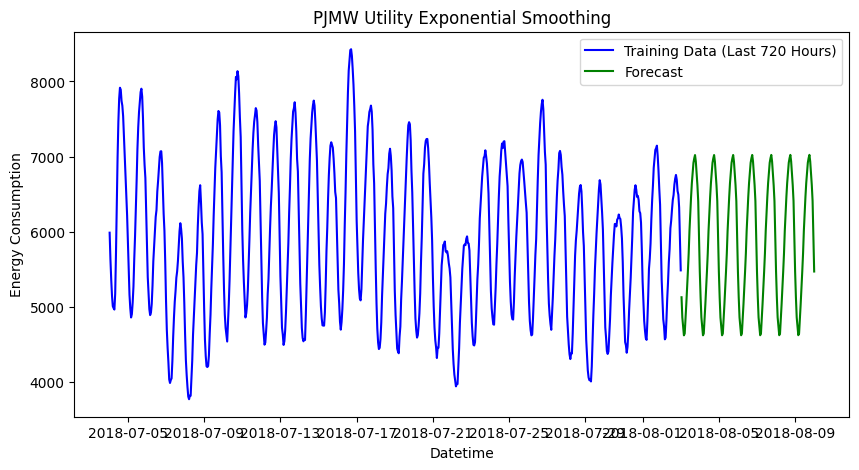

Root Mean Square Error (RMSE) for PJMW Utility: 373.11


In [ ]:
# Iterate through each utility and apply Holt-Winters model
for utility_file, utility_name in zip(utilities, utility_names):
    file_path = os.path.join(base_dir, utility_file)

    # Check if the file exists
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")
        continue

    print(f"Attempting to load file: {file_path}")

    try:
        utility_data = pd.read_csv(file_path, index_col=0)
    except Exception as e:
        print(f"Error loading {utility_name}: {e}")
        continue

    utility_data.index = pd.to_datetime(utility_data.index)

    # Handle duplicate timestamps by removing duplicates or aggregating
    if utility_data.index.duplicated().any():
        print(f"Duplicate timestamps found in {utility_name}, handling duplicates.")
        utility_data = utility_data[~utility_data.index.duplicated(keep='first')]

    # Aggregate data to daily frequency to reduce noise and improve model forecasting (Optional)
    # utility_data = utility_data.resample('D').mean()  # Aggregating to daily to reduce noise

    # Ensure the data frequency is hourly
    utility_data = utility_data.asfreq("H")

    # Check and fill missing values if necessary
    if utility_data.isnull().sum().sum() > 0:
        utility_data = utility_data.ffill()
        print(f"Missing values were filled in {utility_name}.")

    # Determine if the data is strictly positive and set seasonal type accordingly
    if (utility_data <= 0).any().any():
        print(f"Dataset for {utility_name} contains non-positive values. Switching to additive model.")
        seasonal_type = "add"
    else:
        seasonal_type = "mul"

    # Apply the Holt-Winters model to the data with tuned parameters
    try:
        model = ExponentialSmoothing(
            utility_data,
            trend="add",  # Additive trend component
            seasonal=seasonal_type,
            seasonal_periods=seasonal_periods
        )

        # Fit model and let it optimize parameters to avoid overfitting
        model_fit = model.fit(optimized=True)

        # Generate forecast for the next week (168 hours)
        forecast = model_fit.forecast(steps=168)

        # Cap extreme forecast values to avoid unrealistic predictions
        forecast[forecast < 0] = 0
        forecast[forecast > utility_data.max().max() * 1.5] = utility_data.max().max() * 1.5

        # Plotting the actual and predicted values
        plt.figure(figsize=(10, 5))
        plt.plot(utility_data[-720:], label="Training Data (Last 720 Hours)", color="blue")
        plt.plot(forecast, label="Forecast", color="green")
        plt.title(f"{utility_name} Exponential Smoothing")
        plt.xlabel("Datetime")
        plt.ylabel("Energy Consumption")
        plt.legend()
        plt.show()

        # Calculate RMSE for forecast
        test_data = utility_data[-168:]  # Assuming test data is the last week
        rmse = np.sqrt(mean_squared_error(test_data, forecast))
        print(f"Root Mean Square Error (RMSE) for {utility_name}: {rmse:.2f}")

    except Exception as e:
        print(f"Error fitting model for {utility_name}: {e}")

# Anaylsis 

### Energy Consumption Forecasts: 
* Data Used: The graphs and analysis are based on hourly energy consumption data for various utility companies. This data spans a period that includes multiple years, allowing for the modeling of seasonal and trend components over time.
* Insights from Graphs: The graphs compare forecasted energy consumption to historical data for each utility company. The blue line shows the training data (recent historical energy use), while the green line represents the model's forecast for the upcoming 7 days. These graphs help visualize how well the model is capturing the patterns in the data, both before and after hyperparameter tuning.
* Ultimate Takeaway: The tuned models (green line) typically provide more stable and realistic forecasts compared to the original models, which sometimes show unrealistic spikes or drops. This suggests that hyperparameter tuning improved the accuracy and reliability of the forecasts, making the model better suited for real-world applications like predicting future energy demands to optimize supply management.

### What is Holt-Winters Exponential Smoothing?
* Exponential Smoothing is a technique used for time series forecasting that involves weighting past observations with exponentially decreasing weights.
* The Holt-Winters method extends this by including components for:
* Trend (how the data changes over time, e.g., increasing or decreasing)
* Seasonality (regular, repeating patterns within the data, like daily or yearly cycles)

### Comparing the Before and After Tuning
* The hyperparameter-tuned model used specific values for smoothing and adjusted osme of the configurations which allowed for more felxibility in parameter tuning to avoid negavitive forcastes that I was recieveing earlier in the code.
* The orginal Models show that some utilities like "COMED" diverge or go negative which is unrealistic for energy consumption. After Tuning, these models show more stable, relalistic values.
* THe Root Mean Square Error (RMSE) were lower after hyperparameter tuning for emost utilities.
* After Tuning, the forcast patterns were smoother and more consistent with historical data. Especially seen in "COMED"